# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Data Examination

In [4]:
figsize=(20, 5)
plt.style.use('ggplot')

In [5]:
data = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

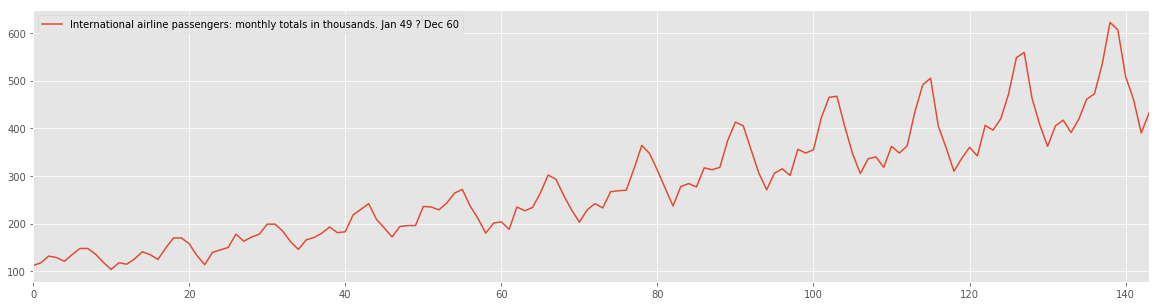

In [6]:
data.plot(figsize=figsize)

In [7]:
dataset = data.values
dataset = dataset.astype('float32')

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scale_dataset = scaler.fit_transform(dataset)

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Train Loop

In [10]:
class TrainContext(object):
    def __init__(self, model, dataset, trainX, trainY, testX, testY):
        self.model = model
        self.dataset = dataset
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
    
def train_model(dataset, look_back):
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=32, batch_size=1, verbose=2)
    
    return TrainContext(model, dataset, trainX, trainY, testX, testY)

# Train With Scaling

In [11]:
scaled = train_model(scale_dataset, 1)

Epoch 1/32
1s - loss: 0.0431
Epoch 2/32
0s - loss: 0.0209
Epoch 3/32
0s - loss: 0.0161
Epoch 4/32
0s - loss: 0.0148
Epoch 5/32
0s - loss: 0.0139
Epoch 6/32
0s - loss: 0.0129
Epoch 7/32
0s - loss: 0.0120
Epoch 8/32
0s - loss: 0.0111
Epoch 9/32
0s - loss: 0.0102
Epoch 10/32
0s - loss: 0.0092
Epoch 11/32
0s - loss: 0.0083
Epoch 12/32
0s - loss: 0.0074
Epoch 13/32
0s - loss: 0.0066
Epoch 14/32
0s - loss: 0.0057
Epoch 15/32
0s - loss: 0.0050
Epoch 16/32
0s - loss: 0.0043
Epoch 17/32
0s - loss: 0.0038
Epoch 18/32
0s - loss: 0.0034
Epoch 19/32
0s - loss: 0.0029
Epoch 20/32
0s - loss: 0.0026
Epoch 21/32
0s - loss: 0.0025
Epoch 22/32
0s - loss: 0.0023
Epoch 23/32
0s - loss: 0.0022
Epoch 24/32
0s - loss: 0.0021
Epoch 25/32
0s - loss: 0.0021
Epoch 26/32
0s - loss: 0.0021
Epoch 27/32
0s - loss: 0.0020
Epoch 28/32
0s - loss: 0.0021
Epoch 29/32
0s - loss: 0.0020
Epoch 30/32
0s - loss: 0.0021
Epoch 31/32
0s - loss: 0.0021
Epoch 32/32
0s - loss: 0.0020


# Train Without Scaling

In [12]:
unscaled = train_model(dataset, 1)

Epoch 1/32
1s - loss: 51252.2753
Epoch 2/32
0s - loss: 51124.3700
Epoch 3/32
0s - loss: 50999.0819
Epoch 4/32
0s - loss: 50873.6523
Epoch 5/32
0s - loss: 50748.5803
Epoch 6/32
0s - loss: 50623.7521
Epoch 7/32
0s - loss: 50498.6280
Epoch 8/32
0s - loss: 50374.3924
Epoch 9/32
0s - loss: 50249.9331
Epoch 10/32
0s - loss: 50125.9624
Epoch 11/32
0s - loss: 50002.4404
Epoch 12/32
0s - loss: 49878.8537
Epoch 13/32
0s - loss: 49755.8787
Epoch 14/32
0s - loss: 49632.8975
Epoch 15/32
0s - loss: 49510.3048
Epoch 16/32
0s - loss: 49387.6089
Epoch 17/32
0s - loss: 49265.7217
Epoch 18/32
0s - loss: 49143.3549
Epoch 19/32
0s - loss: 49021.6621
Epoch 20/32
0s - loss: 48899.9711
Epoch 21/32
0s - loss: 48778.6974
Epoch 22/32
0s - loss: 48657.3375
Epoch 23/32
0s - loss: 48536.4294
Epoch 24/32
0s - loss: 48415.7041
Epoch 25/32
0s - loss: 48295.3478
Epoch 26/32
0s - loss: 48174.8455
Epoch 27/32
0s - loss: 48054.8495
Epoch 28/32
0s - loss: 47934.8520
Epoch 29/32
0s - loss: 47815.3174
Epoch 30/32
0s - loss: 

# Evaluate

In [13]:
def plot_predict(ctx, look_back):
    # make predictions
    trainPredict = ctx.model.predict(ctx.trainX)
    testPredict = ctx.model.predict(ctx.testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([ctx.trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([ctx.testY])

    dataset = ctx.dataset
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

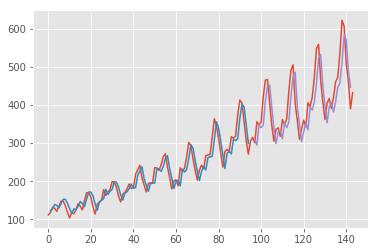

In [14]:
plot_predict(scaled, 1)

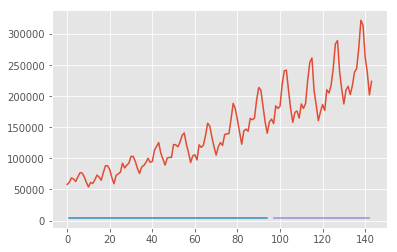

In [15]:
plot_predict(unscaled, 1)

# Let's Explore Our SingGen

In [21]:
type(unscaled.dataset)

numpy.ndarray

In [22]:
unscaled.dataset.shape

(144, 1)

In [24]:
from singen import SinP1Gen

In [25]:
g = SinP1Gen(timesteps=144)

In [26]:
x, y = g.batch()

In [33]:
xdata = x.squeeze(axis=0)
xdata.shape

(144, 1)

### Rerun with this new data

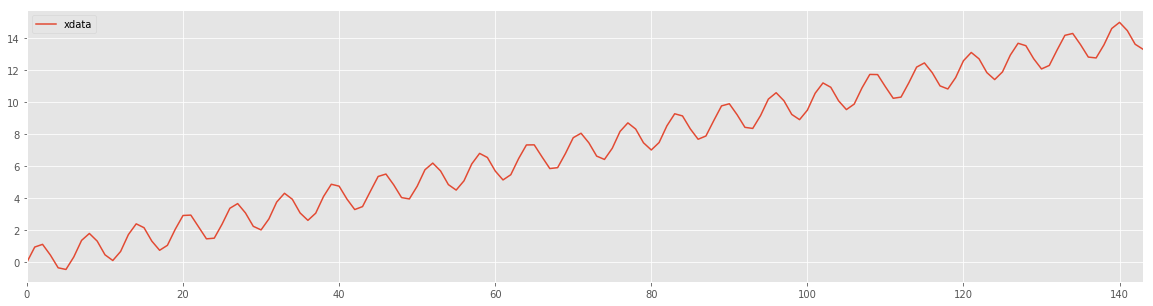

In [35]:
pd.DataFrame({"xdata": xdata.squeeze()}).plot(figsize=figsize)

In [36]:
xdata_scale = scaler.fit_transform(xdata)

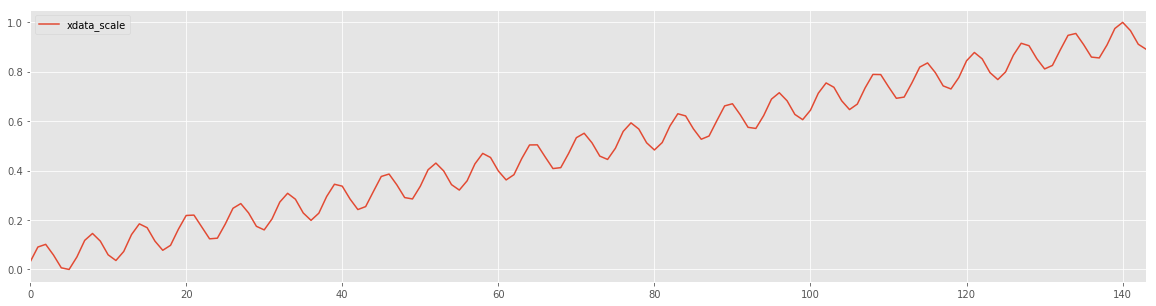

In [38]:
pd.DataFrame({"xdata_scale": xdata_scale.squeeze()}).plot(figsize=figsize)

In [39]:
xctx = train_model(xdata_scale, 1)

Epoch 1/32
2s - loss: 0.1252
Epoch 2/32
0s - loss: 0.0639
Epoch 3/32
0s - loss: 0.0382
Epoch 4/32
0s - loss: 0.0301
Epoch 5/32
0s - loss: 0.0278
Epoch 6/32
0s - loss: 0.0260
Epoch 7/32
0s - loss: 0.0242
Epoch 8/32
0s - loss: 0.0224
Epoch 9/32
0s - loss: 0.0209
Epoch 10/32
0s - loss: 0.0191
Epoch 11/32
0s - loss: 0.0173
Epoch 12/32
0s - loss: 0.0156
Epoch 13/32
0s - loss: 0.0139
Epoch 14/32
0s - loss: 0.0123
Epoch 15/32
0s - loss: 0.0110
Epoch 16/32
0s - loss: 0.0094
Epoch 17/32
0s - loss: 0.0080
Epoch 18/32
0s - loss: 0.0068
Epoch 19/32
0s - loss: 0.0057
Epoch 20/32
0s - loss: 0.0048
Epoch 21/32
0s - loss: 0.0042
Epoch 22/32
0s - loss: 0.0035
Epoch 23/32
0s - loss: 0.0030
Epoch 24/32
0s - loss: 0.0027
Epoch 25/32
0s - loss: 0.0025
Epoch 26/32
0s - loss: 0.0023
Epoch 27/32
0s - loss: 0.0021
Epoch 28/32
0s - loss: 0.0021
Epoch 29/32
0s - loss: 0.0021
Epoch 30/32
0s - loss: 0.0020
Epoch 31/32
0s - loss: 0.0020
Epoch 32/32
0s - loss: 0.0020


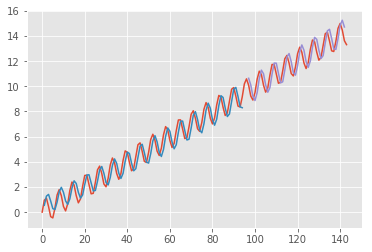

In [40]:
plot_predict(xctx, 1)

In [41]:
help(MinMaxScaler)

Help on class MinMaxScaler in module sklearn.preprocessing.data:

class MinMaxScaler(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Transforms features by scaling each feature to a given range.
 |  
 |  This estimator scales and translates each feature individually such
 |  that it is in the given range on the training set, i.e. between
 |  zero and one.
 |  
 |  The transformation is given by::
 |  
 |      X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
 |      X_scaled = X_std * (max - min) + min
 |  
 |  where min, max = feature_range.
 |  
 |  This transformation is often used as an alternative to zero mean,
 |  unit variance scaling.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_scaler>`.
 |  
 |  Parameters
 |  ----------
 |  feature_range : tuple (min, max), default=(0, 1)
 |      Desired range of transformed data.
 |  
 |  copy : boolean, optional, default True
 |      Set to False to perform inplace row normalization and avoid a
 |   

### first, what is up with this shape?

In [46]:
xctx.trainX.shape

(94, 1, 1)

In [51]:
xctx.trainX.squeeze()[0:10]

array([ 0.02972468,  0.09070409,  0.10157426,  0.05829618,  0.00661446,
        0.        ,  0.05048905,  0.11761718,  0.14562204,  0.11471105])

In [52]:
xctx.trainY.squeeze()[0:10]

array([ 0.09070409,  0.10157426,  0.05829618,  0.00661446,  0.        ,
        0.05048905,  0.11761718,  0.14562204,  0.11471105,  0.0592586 ])

In [54]:
import tensorflow as tf

In [59]:
help(tf.nn.l2_normalize)

Help on function l2_normalize in module tensorflow.python.ops.nn_impl:

l2_normalize(x, dim, epsilon=1e-12, name=None)
    Normalizes along dimension `dim` using an L2 norm.
    
    For a 1-D tensor with `dim = 0`, computes
    
        output = x / sqrt(max(sum(x**2), epsilon))
    
    For `x` with more dimensions, independently normalizes each 1-D slice along
    dimension `dim`.
    
    Args:
      x: A `Tensor`.
      dim: Dimension along which to normalize.  A scalar or a vector of
        integers.
      epsilon: A lower bound value for the norm. Will use `sqrt(epsilon)` as the
        divisor if `norm < sqrt(epsilon)`.
      name: A name for this operation (optional).
    
    Returns:
      A `Tensor` with the same shape as `x`.

